In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv
/kaggle/input/icr-identify-age-related-conditions/greeks.csv
/kaggle/input/icr-identify-age-related-conditions/train.csv
/kaggle/input/icr-identify-age-related-conditions/test.csv


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import seaborn as sns
from sklearn.model_selection import GridSearchCV, KFold
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, balanced_accuracy_score
from sklearn.metrics import accuracy_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
train = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/train.csv")
test = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/test.csv")
greeks = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/greeks.csv")
sample_submission = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv")

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

In [5]:
nan_cols = train.columns[train.isnull().any()].tolist()
numerical_cols = train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = train.select_dtypes(include=['object']).columns.tolist()
print(f"Shape of the dataframe: {train.shape}\n")
print(f"Columns with NaN values: {nan_cols}\n")
print(f'Numerical columns: {numerical_cols}\n')
print(f'Categorical columns: {categorical_cols}\n')
print(f"Class balance: {train['Class'].value_counts()}")

Shape of the dataframe: (617, 58)

Columns with NaN values: ['BQ', 'CB', 'CC', 'DU', 'EL', 'FC', 'FL', 'FS', 'GL']

Numerical columns: ['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB', 'EE', 'EG', 'EH', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class']

Categorical columns: ['Id', 'EJ']

Class balance: 0    509
1    108
Name: Class, dtype: int64


In [6]:
def encode_discrete(df, columns):
    df_copy = df.copy()
    if isinstance(columns, str):
        columns = [columns]
    for col in columns:
        le = LabelEncoder()
        df_copy[col] = le.fit_transform(df_copy[col].astype(str))
    return df_copy

In [7]:
def ffil(df):
    df_copy = df.copy()
    df_copy = df_copy.fillna(method = 'ffill')
    return df_copy

In [8]:
def move_class_label(df):
    df_copy = df.copy()
    if 'Class' in df_copy.columns:
        class_col = df_copy.pop('Class')
        df_copy['Class'] = class_col
    
    return df_copy

In [9]:
def preprocess_datasets(df):
    df = encode_discrete(df, "EJ")
    df = ffil(df)
    df = move_class_label(df)
    return df

train = preprocess_datasets(train)
test = preprocess_datasets(test)

In [10]:
X = train.iloc[:, 1:-1]
y = train.iloc[:, -1]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

In [12]:
def train_xgb(X, y):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [2, 4, 6, 8],
        'learning_rate': [0.01, 0.1, 0.2],
    }

    xgb = XGBClassifier(eval_metric='logloss')

    grid_search = GridSearchCV(
        xgb,
        param_grid,
        cv=KFold(n_splits=5, shuffle=True, random_state=42),  # 5-fold cross-validation
        scoring=make_scorer(balanced_accuracy_score),  # Use balanced accuracy as the scoring metric
        verbose=1,  # If you want to see what Grid Search is doing, set verbose=2
        n_jobs=-1,  # Use all available processors
    )
    grid_search.fit(X, y) 
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best accuracy score: {grid_search.best_score_}")    
    return grid_search

grid_search = train_xgb(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Best parameters: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 100}
Best accuracy score: 0.8110341899913127


In [13]:
model = grid_search.best_estimator_
y_valid_predictions = model.predict(X_valid)

In [14]:
def evaluate_model(model, y_actual, y_predicted):
    print('LogLoss: ', model.score(y_actual, y_predicted))
    print('Accuracy: ', accuracy_score(y_actual, y_predicted))
    
evaluate_model(model, y_valid, y_valid_predictions)

LogLoss:  0.9354838709677419
Accuracy:  0.9354838709677419


In [15]:
y_pred = model.predict(X_valid)

def get_classification_report(y_actual, y_predicted):
    print('Classification Report:')
    print(classification_report(y_actual, y_predicted))
    print('Confusion Matrix:')
    print(confusion_matrix(y_actual, y_predicted))
    
get_classification_report(y_actual=y_valid, y_predicted=y_pred)

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       101
           1       0.94      0.70      0.80        23

    accuracy                           0.94       124
   macro avg       0.94      0.84      0.88       124
weighted avg       0.94      0.94      0.93       124

Confusion Matrix:
[[100   1]
 [  7  16]]


Text(50.722222222222214, 0.5, 'Truth')

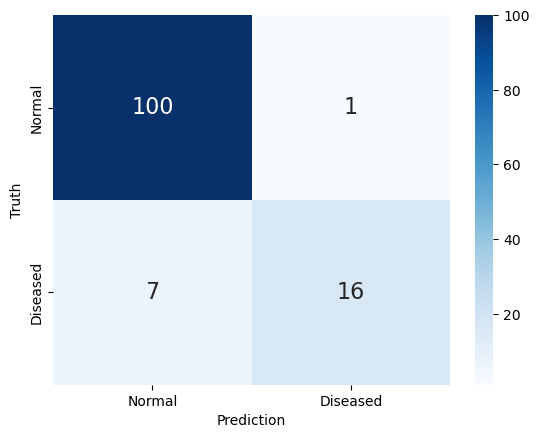

In [16]:
cm = confusion_matrix(y_valid, y_pred)
class_names = ['Normal', 'Diseased']
ax = sns.heatmap(cm, annot = True, fmt = '.0f', cmap = "Blues", annot_kws = {"size": 16},\
           xticklabels = class_names, yticklabels = class_names)
ax.set_xlabel("Prediction")
ax.set_ylabel("Truth")

In [17]:
X_full = scaler.fit_transform(X)
grid_search_for_submission = train_xgb(X_full, y)
model = grid_search_for_submission.best_estimator_
y_full_predictions = model.predict(X_full)

print("Results on full training data:")
evaluate_model(model, y, y_full_predictions)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 50}
Best accuracy score: 0.858039092613453
Results on full training data:
LogLoss:  0.17504051863857376
Accuracy:  1.0


In [18]:
X_submission = test.iloc[:, 1:]

In [19]:
X_submission = scaler.transform(X_submission)
y_submission_pred = model.predict_proba(X_submission)

y_submission_pred

array([[0.7650116 , 0.23498839],
       [0.7650116 , 0.23498839],
       [0.7650116 , 0.23498839],
       [0.7650116 , 0.23498839],
       [0.7650116 , 0.23498839]], dtype=float32)

In [20]:
submission = pd.DataFrame(test["Id"], columns = ["Id"])
y_pred_df = pd.DataFrame(y_submission_pred, columns = ['0', '1'])
submission["class_0"] = y_pred_df['0']
submission["class_1"] = y_pred_df['1']

In [21]:
submission

,Id,class_0,class_1
0,00eed32682bb,0.765012,0.234988
1,010ebe33f668,0.765012,0.234988
2,02fa521e1838,0.765012,0.234988
3,040e15f562a2,0.765012,0.234988
4,046e85c7cc7f,0.765012,0.234988


In [22]:
submission.to_csv('submission.csv',index = False)